<a href="https://colab.research.google.com/github/jojowaranyucareer-ctrl/Weatherwise_Waranyu.B/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [76]:
# # 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
# !pip install hands-on-ai
# !pip install pyinputplus

In [77]:
import os

# Configure your provider
os.environ['HANDS_ON_AI_SERVER'] = 'https://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'llama3.2'
os.environ['HANDS_ON_AI_API_KEY'] = 'e6903b35e08f4227b3a4cbee5b836408' #Demo key, get your own API at https://ollama.com/
os.environ["OPENWEATHER_API_KEY"] = "3a10e176bbe73766db6e4d09a4bd96d0"  # Demo key, get your own at https://openweathermap.org/api

# Uncomment this to test the server and API are working (if error the server maybe down or API is incorrect)
# from hands_on_ai.chat import get_response
# print(get_response("As a current weather in Australia, Perth today is 30 degrees celcius, with uv index of, and partial clouds, Can i play outddoor basketball?"))

## 📦 Setup and Configuration
Import required packages and setup environment.

In [78]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
from hands_on_ai.chat import get_response
import os
import re
from typing import Dict, Any, List, Optional, Tuple, Union, TypedDict
import requests
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime
from collections import defaultdict

## 🌤️ Weather Data Functions

In [79]:
# Define get_weather_data() function here
class ParsedWeather(TypedDict, total=False):
    location: str
    forecast_days: int
    error: Optional[str]
    current: Dict[str, Any]
    daily: List[Dict[str, Any]]


def openWeather_getWeather(city: str, units: str = "metric"):
    api_key = os.getenv("OPENWEATHER_API_KEY")
    if not api_key:
            return None
    try:
            CITY = city
            UNITS = units  # metric for °C or "imperial" for °F
            # Step 1: Call the 5-day forecast API
            url = f"https://api.openweathermap.org/data/2.5/forecast?q={CITY}&appid={api_key}&units={UNITS}"
            response = requests.get(url)
            data = response.json()
            return data
    except Exception as e:
            print(f"Error fetching weather data: {e}")
            return None


def get_temps(data):
        daily_temps = {}

        for item in data["list"]:
                dt_txt = item["dt_txt"] # e.g., '2025-10-16 03:00:00'
                date_str = dt_txt.split(" ")[0] # Just the date part
                temp = item["main"]["temp"]

                if date_str not in daily_temps:
                        daily_temps[date_str] = []

                daily_temps[date_str].append(temp)

        return daily_temps


def get_weather_data(city: str, forecast_days: int = 5):
    """
    Retrieve weather data for a specified location.

    Args:
            location (str): City or location name
            forecast_days (int): Number of days to forecast (1-5)

    Returns:
            dict: Weather data including current conditions and forecast
    """
    try:
            response = openWeather_getWeather(city=city, units="metric")
            return response
    except Exception as e:
            response["error"] = f"Failed to fetch weather data: {e}"
            return response

## 📊 Visualisation Functions

In [80]:
# Define create_temperature_visualisation()
def create_temperature_visualisation(weather_data: Dict[str, Any], num_days: int = 5, output_type: str = 'display'):
        """
        Create visualisation of temperature data using average daily temperatures.

        Args:
                weather_data (dict): The processed weather data
                num_days (int): The number of days to display in the chart.
                output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

        Returns:
                If output_type is 'figure', returns the matplotlib figure object
                Otherwise, displays the visualisation in the notebook
        """

        # get daily forecast data
        daily = weather_data.get("list", [])
        if not daily:
                print("No daily forecast data available to plot temperatures.")
                return None

        daily_temps = get_temps(weather_data)
        # Slice the data to include only the requested number of days
        sliced_dates = list(daily_temps.keys())[:num_days]
        sliced_temps = [sum(daily_temps[date]) / len(daily_temps[date]) if daily_temps[date] else 0 for date in sliced_dates]


        fig, ax = plt.subplots()
        ax.plot(sliced_dates, sliced_temps, marker='o', label='Average Temp (°C)')
        ax.set_title(f"Daily Average Temperature Forecast for {num_days} Days")
        ax.set_xlabel("Day")
        ax.set_ylabel("Temperature (°C)")
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()

        if output_type == 'figure':
                return fig
        else:
                plt.show()
                return None

In [81]:
# Define create_precipitation_visualisation() here

def create_precipitation_visualisation(weather_data: Dict[str, Any], num_days: int = 5, output_type: str = 'display'):
        """
        Create visualisation of precipitation data.

        Args:
                weather_data (dict): The processed weather data
                num_days (int): The number of days to display in the chart.
                output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

        Returns:
                If output_type is 'figure', returns the matplotlib figure object
                Otherwise, displays the visualisation in the notebook
        """
        # OpenWeatherMap provides data in 3-hour intervals under the 'list' key
        forecast_list = weather_data.get("list", [])
        if not forecast_list:
                print("No forecast data available to plot precipitation.")
                return None

        daily_precipitation = defaultdict(float)
        date_labels = []

        for item in forecast_list:
            dt_txt = item["dt_txt"] # e.g., '2025-10-16 03:00:00'
            date_str = dt_txt.split(" ")[0] # Just the date part

            # Add date to labels if not already present (ensures unique daily labels)
            if date_str not in date_labels:
                date_labels.append(date_str)

            # OpenWeatherMap uses 'rain' or 'snow' keys with a '3h' sub-key
            # Total precipitation is the sum of rain and snow in the 3-hour period
            precip_3h = item.get("rain", {}).get("3h", 0) + item.get("snow", {}).get("3h", 0)
            daily_precipitation[date_str] += precip_3h # Accumulate precipitation for the day


        # Sort the daily precipitation data by date
        sorted_dates = sorted(daily_precipitation.keys())
        sorted_precipitation_totals = [daily_precipitation[date] for date in sorted_dates]


        # Format date labels for the plot
        formatted_labels: List[str] = []
        for date_str in sorted_dates:
            try:
                formatted_labels.append(datetime.strptime(date_str, "%Y-%m-%d").strftime("%a %d"))
            except Exception:
                formatted_labels.append(date_str)


        fig, ax = plt.subplots()
        # Limit to the number of days specified by the user
        num_days_to_plot = min(num_days, len(sorted_dates))
        ax.bar(formatted_labels[:num_days_to_plot], sorted_precipitation_totals[:num_days_to_plot], color="#4e79a7")
        ax.set_title(f"Daily Total Precipitation Forecast for {num_days_to_plot} Days")
        ax.set_xlabel("Day")
        ax.set_ylabel("Precipitation (mm)")
        plt.tight_layout()

        if output_type == 'figure':
                return fig
        else:
                plt.show()
                return None

## 🤖 Natural Language Processing

In [82]:
# Define parse_weather_question() and generate_weather_response() here
def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    parsed_info = {
        "question": question, # Keep the original question
        "location": None,
        "time_period": None, # e.g., "today", "tomorrow", "next 5 days"
        "weather_attribute": None # e.g., "temperature", "rain", "wind"
    }

    # Basic location extraction (can be improved)
    # Look for capitalized words that might be locations
    words = question.split()
    capitalized_words = [word for word in words if word and word[0].isupper()]
    # This is a very simple approach and might not be accurate for all questions
    if capitalized_words:
        # Assume the first capitalized word is the location (a very rough heuristic)
        parsed_info["location"] = capitalized_words[0]

    # Basic time period extraction (can be improved)
    question_lower = question.lower()
    if "today" in question_lower:
        parsed_info["time_period"] = "today"
    elif "tomorrow" in question_lower:
        parsed_info["time_period"] = "tomorrow"
    elif "next" in question_lower and "day" in question_lower:
         # Attempt to extract number of days
         match = re.search(r"next\s+(\d+)\s+days", question_lower)
         if match:
              parsed_info["time_period"] = f"next {match.group(1)} days"
         else:
              parsed_info["time_period"] = "next few days" # Default if number not found

    # Basic weather attribute extraction (can be improved)
    if "temperature" in question_lower or "how hot" in question_lower or "how cold" in question_lower:
        parsed_info["weather_attribute"] = "temperature"
    if "rain" in question_lower or "precipitation" in question_lower:
        parsed_info["weather_attribute"] = "precipitation"
    if "wind" in question_lower or "windy" in question_lower:
        parsed_info["weather_attribute"] = "wind"


    return parsed_info

## 🧭 User Interface

In [83]:
# Define menu functions using pyinputplus or ipywidgets here

# Initialize global variables
_LAST_WEATHER = None
_LAST_LOCATION = None
_LAST_FORECAST_DAYS = 5

# --- Helper Function for Temperature Advice ---
def get_temperature_advice(average_temp: float) -> str:
    """
    Provides temperature-based advice.

    Args:
        average_temp (float): The average temperature in Celsius.

    Returns:
        str: Advice based on the temperature.
    """
    if average_temp > 32:
        return "Advice: 🔥 It's scorching hot out there! Best to stay indoors and crank up the AC."
    elif average_temp >= 27:
        return "Advice: ☀️ Feeling quite warm today! Light clothing and sunscreen are your friends."
    elif average_temp >= 23:
        return "Advice: 👍 Perfect weather today! Enjoy your time outside!"
    elif average_temp >= 17:
        return "Advice: 🧣 A bit chilly! Don't forget a warm layer if you're heading out."
    else: # Covers temperatures below 17
        return "Advice: 🥶 Brrr, it's freezing! Stay cozy inside and keep warm."


# --- Button Click Handlers ---

def on_fetch_button_clicked(b, location_input, days_input, output_area):
    """
    Handles the click event for the "Fetch Weather Forecast" button.
    Fetches weather data, displays current conditions, and provides temperature advice for today.
    """
    with output_area:
        # Clear previous output
        output_area.clear_output()

        # Access global variables for last fetched weather data and location
        global _LAST_WEATHER, _LAST_LOCATION, _LAST_FORECAST_DAYS

        # Get the location entered by the user
        loc = location_input.value
        if not loc:
            print("⚠️ Please enter a location.")
            return

        # Fetch weather data for the specified location
        # Fetch 6 days as OpenWeatherMap provides 5-day forecast in 3-hour steps
        days = 6
        data = get_weather_data(loc, forecast_days=days)

        # Store the fetched data and location in global variables
        _LAST_WEATHER = data
        _LAST_LOCATION = loc
        _LAST_FORECAST_DAYS = days

        # Check if weather data was successfully retrieved
        if data and data.get("list"):
            # --- Display Current Weather Conditions ---
            if data["list"]:
                current = data["list"][0] # Get the first data point for current conditions
                current_temp = current["main"]["temp"]
                current_description = current["weather"][0]["description"]
                humidity = current["main"]["humidity"]
                wind_speed = current["wind"]["speed"]

                print(f"✨ Weather for {loc}: ✨")
                print(f"🌡️ Currently: {current_temp:.1f}°C with {current_description}, 💧 Humidity: {humidity}%, 💨 Wind: {wind_speed} m/s")

            # --- Calculate and Display Today's Average Temperature and Advice ---
            daily_temps = get_temps(data)
            if daily_temps:
                # Get the date for the first day (today)
                first_day_date = list(daily_temps.keys())[0]
                # Get all temperature readings for today
                temps = daily_temps[first_day_date]
                # Calculate the average temperature for today
                average_temp = sum(temps) / len(temps) if temps else 0

                print(f"☀️ Average temperature for Today ({first_day_date}): {average_temp:.2f}°C")
                # Get and print temperature-based advice using the helper function
                print(get_temperature_advice(average_temp))

            else:
                 print("😔 Could not retrieve daily temperature data for the specified location.")

        # Handle cases where weather data fetching failed
        elif data and data.get("message"):
             print(f"❌ Error fetching weather data: {data['message']}")
        else:
             print("❓ Could not retrieve weather data for the specified location. Please check the location name.")


def on_temp_chart_button_clicked(b, location_input, days_input, output_area):
    """
    Handles the click event for the "Show Temperature Chart" button.
    Displays a temperature forecast chart.
    """
    with output_area:
        output_area.clear_output()
        global _LAST_WEATHER, _LAST_LOCATION, _LAST_FORECAST_DAYS
        loc = location_input.value
        if not loc:
            print("⚠️ Please enter a location.")
            return
        # Fetch if no data or location changed since last fetch
        if not _LAST_WEATHER or _LAST_LOCATION != loc:
            print(f"🔄 Fetching weather data for {loc}...")
            days = 6
            data = get_weather_data(loc, forecast_days=days)
            _LAST_WEATHER = data
            _LAST_LOCATION = loc
            _LAST_FORECAST_DAYS = days
            if not data or data.get("message"):
                print("❌ Could not retrieve weather data. Please check location.")
                return

        # Check if weather data is available for charting
        if not _LAST_WEATHER or not _LAST_WEATHER.get("list"):
            print("📊 Weather data is not available to create chart. Please fetch weather first.")
            return

        # Get the number of days to chart from the input widget
        num_days_chart = days_input.value
        # Create and display the temperature visualisation
        print("📈 Displaying temperature chart...")
        create_temperature_visualisation(_LAST_WEATHER, num_days=num_days_chart, output_type='display')


def on_precip_chart_button_clicked(b, location_input, days_input, output_area):
    """
    Handles the click event for the "Show Precipitation Chart" button.
    Displays a precipitation forecast chart.
    """
    with output_area:
        output_area.clear_output()
        global _LAST_WEATHER, _LAST_LOCATION, _LAST_FORECAST_DAYS
        loc = location_input.value
        if not loc:
            print("⚠️ Please enter a location.")
            return
        # Fetch if no data or location changed since last fetch
        if not _LAST_WEATHER or _LAST_LOCATION != loc:
            print(f"🔄 Fetching weather data for {loc}...")
            days = 6
            data = get_weather_data(loc, forecast_days=days)
            _LAST_WEATHER = data
            _LAST_LOCATION = loc
            _LAST_FORECAST_DAYS = days
            if not data or data.get("message"):
                print("❌ Could not retrieve weather data. Please check location.")
                return

        # Check if weather data is available for charting
        if not _LAST_WEATHER or not _LAST_WEATHER.get("list"):
            print("📊 Weather data is not available to create chart. Please fetch weather first.")
            return

        # Get the number of days to chart from the input widget
        num_days_chart = days_input.value
        # Create and display the precipitation visualisation
        print("💧 Displaying precipitation chart...")
        create_precipitation_visualisation(_LAST_WEATHER, num_days=num_days_chart, output_type='display')


def on_should_go_outside_button_clicked(b, location_input, output_area):
    """
    Handles the click event for the "Should we go outside tomorrow?" button.
    Provides advice on whether to go outside based on tomorrow's forecast.
    """
    with output_area:
        output_area.clear_output()
        global _LAST_WEATHER, _LAST_LOCATION, _LAST_FORECAST_DAYS
        loc = location_input.value
        if not loc:
            print("⚠️ Please enter a location.")
            return

        # Fetch if no data or location changed since last fetch
        if not _LAST_WEATHER or _LAST_LOCATION != loc:
            print(f"🔄 Fetching weather data for {loc}...")
            days = 6
            data = get_weather_data(loc, forecast_days=days)
            _LAST_WEATHER = data
            _LAST_LOCATION = loc
            _LAST_FORECAST_DAYS = days
            if not data or data.get("message"):
                print("❌ Could not retrieve weather data. Please check location.")
                return

        # Check if sufficient weather data is available for tomorrow's forecast
        if not _LAST_WEATHER or not _LAST_WEATHER.get("list") or len(_LAST_WEATHER.get("list", [])) <= 8:
            print("📊 Weather data is not available for tomorrow's forecast. Please fetch weather first or check if forecast extends to tomorrow.")
            return

        # Extract tomorrow's data points (assuming data points 8-15 cover tomorrow in 3-hour intervals)
        tomorrow_data_points = _LAST_WEATHER["list"][8:16]
        if tomorrow_data_points:
            # Calculate average temperature for tomorrow
            tomorrow_temps = [item["main"]["temp"] for item in tomorrow_data_points]
            average_temp_tomorrow = sum(tomorrow_temps) / len(tomorrow_temps) if tomorrow_temps else 0

            # Calculate total precipitation for tomorrow
            tomorrow_precipitation = sum(item.get("rain", {}).get("3h", 0) + item.get("snow", {}).get("3h", 0) for item in tomorrow_data_points)

            # Get wind speed and description for tomorrow (using the first data point for simplicity)
            tomorrow_wind_speed = tomorrow_data_points[0]["wind"]["speed"]
            tomorrow_weather_description = tomorrow_data_points[0]["weather"][0]["description"]

            # Extract tomorrow's date
            tomorrow_date = tomorrow_data_points[0]["dt_txt"].split(" ")[0]

            # Display tomorrow's weather summary
            print(f"📅 Tomorrow's Weather ({tomorrow_date}) for {loc}:")
            print(f"🌡️ Average Temperature: {average_temp_tomorrow:.2f}°C")
            print(f"💧 Total Precipitation: {tomorrow_precipitation:.2f} mm")
            print(f"💨 Wind Speed: {tomorrow_wind_speed:.2f} m/s")
            print(f"☁️ Conditions: {tomorrow_weather_description}")

            # Provide advice based on tomorrow's weather conditions
            print("\n🤔 Should we go outside tomorrow?")
            if tomorrow_precipitation > 0.5:
                print("🌧️ Advice: It looks like there will be significant rain tomorrow. It might be best to stay inside or be prepared for wet conditions.")
            elif average_temp_tomorrow < 10:
                 print("🥶 Advice: It will be quite cold tomorrow. Bundle up if you go outside!")
            elif average_temp_tomorrow > 30:
                 print("🥵 Advice: It will be quite hot tomorrow. Stay hydrated and seek shade if you go outside.")
            else:
                print("👍 Advice: The weather looks good for going outside tomorrow!")

        else:
            print("😔 Could not retrieve detailed forecast data for tomorrow.")


def on_ask_question_button_clicked(b, location_input, question_input, output_area):
    """
    Handles the click event for the "Ask Weather Question" button.
    Parses the user's question and generates an AI response.
    """
    with output_area:
        output_area.clear_output()
        global _LAST_WEATHER, _LAST_LOCATION
        question = question_input.value
        loc = location_input.value

        if not loc:
            print("⚠️ Please enter a location.")
            return

        if not question:
            print("❓ Please enter a question.")
            return

        # Fetch weather data if none is available or location has changed
        if not _LAST_WEATHER or _LAST_LOCATION != loc:
            print(f"🔄 Fetching weather data for {loc} before answering...")
            days = 6
            data = get_weather_data(loc, forecast_days=days)
            _LAST_WEATHER = data
            _LAST_LOCATION = loc
            _LAST_FORECAST_DAYS = days
            if not data or data.get("message"):
                print("❌ Could not retrieve weather data. Cannot answer question.")
                return

        print("🤖 Asking AI...")
        # Parse the user's question
        parsed_question = parse_weather_question(question)
        # Generate AI response using the parsed question and weather data
        ai_response = generate_weather_response(parsed_question, _LAST_WEATHER)
        print("\n✨ AI Response: ✨")
        print(ai_response)


def on_quit_button_clicked(b, output_area):
    """
    Handles the click event for the "Quit" button.
    Clears the output and prints a goodbye message.
    """
    with output_area:
        output_area.clear_output()
        print("👋 Goodbye!")
        # In a real application, you might want to stop execution here
        # For a notebook, simply printing a message is sufficient


# --- Main UI Function ---

def create_weather_ui():
    """
    Creates and returns the WeatherWise user interface using ipywidgets.
    Organizes input fields, buttons, and output area.
    Links button click events to their respective handler functions.
    """
    # Create input widgets
    location_input = widgets.Text(
        value=_LAST_LOCATION if _LAST_LOCATION else '',
        placeholder='e.g., Paris, Tokyo, Sydney',
        description='📍 Location:',
        disabled=False
    )

    days_input = widgets.IntText(
        value=_LAST_FORECAST_DAYS,
        description='📅 Forecast Days (1-6):',
        disabled=False,
        min=1,
        max=6,
        layout=widgets.Layout(description_width='250 px')
    )

    question_input = widgets.Text(
        value='',
        placeholder='e.g., What is the temperature tomorrow?',
        description='❓ Ask AI a Question:',
        disabled=False
    )

    # Create action buttons
    button_layout = widgets.Layout(width='250px')

    fetch_button = widgets.Button(description="☀️ Fetch Today's Weather", layout=button_layout)
    temp_chart_button = widgets.Button(description="📈 Show Temperature Chart", layout=button_layout)
    precip_chart_button = widgets.Button(description="💧 Show Precipitation Chart", layout=button_layout)
    should_go_outside_button = widgets.Button(description="🏃‍♀️ Should We Go Outside Tomorrow?", layout=button_layout)
    ask_question_button = widgets.Button(description="🤖 Ask Weather Question", layout=button_layout)
    quit_button = widgets.Button(description="👋 Quit", layout=button_layout)

    # Create an output widget to display results
    output_area = widgets.Output()

    # Arrange widgets in a layout
    input_widgets = widgets.VBox([location_input, days_input, question_input])
    button_widgets = widgets.VBox([fetch_button, temp_chart_button, precip_chart_button, should_go_outside_button, ask_question_button, quit_button])

    ui = widgets.VBox([
        widgets.Label("Hello! I'm your WeatherWise assistant, ready to provide weather insights. Let's get started!"),
        input_widgets,
        button_widgets,
        output_area
    ])

    # Link buttons to handlers, passing necessary widgets
    # Using lambda to pass additional arguments to the handler functions
    fetch_button.on_click(lambda b: on_fetch_button_clicked(b, location_input, days_input, output_area))
    temp_chart_button.on_click(lambda b: on_temp_chart_button_clicked(b, location_input, days_input, output_area))
    precip_chart_button.on_click(lambda b: on_precip_chart_button_clicked(b, location_input, days_input, output_area))
    should_go_outside_button.on_click(lambda b: on_should_go_outside_button_clicked(b, location_input, output_area))
    ask_question_button.on_click(lambda b: on_ask_question_button_clicked(b, location_input, question_input, output_area))
    quit_button.on_click(lambda b: on_quit_button_clicked(b, output_area))

    return ui

## 🧩 Main Application Logic

In [84]:
# Tie everything together here

def generate_weather_response(parsed_question: Dict[str, Any], weather_data: Dict[str, Any]) -> str:
    """
    Generate a natural language response to a weather question based on provided weather data.

    Args:
        parsed_question (dict): Parsed question data (includes question string, location, time_period, weather_attribute).
        weather_data (dict): Weather data.

    Returns:
        str: Natural language response.
    """
    question = parsed_question.get("question", "")
    location = parsed_question.get("location")
    time_period = parsed_question.get("time_period")
    weather_attribute = parsed_question.get("weather_attribute")

    if not question:
        return "No question provided."

    # --- Prepare weather context for the AI ---
    weather_context = "Weather information:"

    if not weather_data or not weather_data.get("list"):
        weather_context += " Weather data not available."
    else:
        # Add current weather info
        current = weather_data["list"][0]
        weather_context += f" Current: Temp: {current['main']['temp']:.1f}°C, Conditions: {current['weather'][0]['description']}, Humidity: {current['main']['humidity']}%, Wind: {current['wind']['speed']} m/s."

        # Add forecast data if available and relevant to the time period
        if time_period and len(weather_data.get("list", [])) > 8:
            if time_period == "tomorrow":
                tomorrow_data_points = weather_data["list"][8:16] # Assuming data points 8-15 cover tomorrow
                if tomorrow_data_points:
                    tomorrow_date = tomorrow_data_points[0]["dt_txt"].split(" ")[0]
                    tomorrow_temps = [item["main"]["temp"] for item in tomorrow_data_points]
                    average_temp_tomorrow = sum(tomorrow_temps) / len(tomorrow_temps) if tomorrow_temps else 0
                    tomorrow_precipitation = sum(item.get("rain", {}).get("3h", 0) + item.get("snow", {}).get("3h", 0) for item in tomorrow_data_points)
                    tomorrow_weather_description = tomorrow_data_points[0]["weather"][0]["description"]
                    weather_context += f" Tomorrow ({tomorrow_date}): Average Temp: {average_temp_tomorrow:.2f}°C, Precipitation: {tomorrow_precipitation:.2f} mm, Conditions: {tomorrow_weather_description}."
            elif time_period.startswith("next"):
                 # For "next X days", add a brief summary or just mention forecast is available
                 num_days_str = time_period.split(" ")[1] if len(time_period.split(" ")) > 1 else "few"
                 weather_context += f" Forecast for the next {num_days_str} days is available."


    # --- Construct the prompt for the AI ---
    # Build a more specific question for the AI using parsed info if available
    ai_prompt = f"{weather_context}\n"

    if location:
        ai_prompt += f"Regarding the weather in {location}, "
    if time_period:
         ai_prompt += f"for the period {time_period}, "
    if weather_attribute:
         ai_prompt += f"focusing on the {weather_attribute}, "

    ai_prompt += f"please answer the following question: {question}"


    # --- Get response from the AI ---
    try:
        ai_response = get_response(ai_prompt)
        return ai_response
    except Exception as e:
        return f"Error getting AI response: {e}"

## 🧪 Testing and Examples

In [ ]:
# Include sample input/output for each function
#Testing Weather Data Functions

In [91]:
# Test openWeather_getWeather
print("Testing openWeather_getWeather...")
sample_city = "London"
weather_raw_data = openWeather_getWeather(city=sample_city)

if weather_raw_data:
    print(f"Successfully fetched raw weather data for {sample_city}. Data structure preview:")
    # Display a part of the raw data to show it was fetched
    display(list(weather_raw_data.keys()))
    if weather_raw_data.get("list"):
        print("First item in 'list':")
        display(weather_raw_data["list"][0])
else:
    print(f"Failed to fetch raw weather data for {sample_city}.")

Testing openWeather_getWeather...
Successfully fetched raw weather data for London. Data structure preview:


['cod', 'message', 'cnt', 'list', 'city']

First item in 'list':


{'dt': 1760778000,
 'main': {'temp': 11.88,
  'feels_like': 11.19,
  'temp_min': 11.88,
  'temp_max': 12.57,
  'pressure': 1024,
  'sea_level': 1024,
  'grnd_level': 1020,
  'humidity': 79,
  'temp_kf': -0.69},
 'weather': [{'id': 804,
   'main': 'Clouds',
   'description': 'overcast clouds',
   'icon': '04d'}],
 'clouds': {'all': 100},
 'wind': {'speed': 3.14, 'deg': 119, 'gust': 7.03},
 'visibility': 10000,
 'pop': 0,
 'sys': {'pod': 'd'},
 'dt_txt': '2025-10-18 09:00:00'}

In [92]:
# Test get_temps (requires raw weather data from openWeather_getWeather)
print("\nTesting get_temps...")
if 'weather_raw_data' in locals() and weather_raw_data and weather_raw_data.get("list"):
    daily_temperatures = get_temps(weather_raw_data)
    print("Successfully extracted daily temperatures. Preview:")
    display(daily_temperatures)
else:
    print("Skipping get_temps test as raw weather data is not available or not fetched.")


Testing get_temps...
Successfully extracted daily temperatures. Preview:


{'2025-10-18': [11.88, 12.76, 13.53, 13.97, 13.88],
 '2025-10-19': [14.63, 13.33, 13.28, 13.9, 13.48, 13.12, 13.77, 14.78],
 '2025-10-20': [12.72, 12.81, 12.95, 12.89, 13.47, 13, 13.11, 12.55],
 '2025-10-21': [11.83, 11.32, 10.92, 12.09, 12.4, 13.04, 12.35, 12.03],
 '2025-10-22': [11.56, 10.44, 10.14, 11.15, 14.35, 13.65, 14.4, 15.82],
 '2025-10-23': [15.96, 16.19, 15.21]}

In [93]:
# Test get_weather_data (which uses openWeather_getWeather internally)
print("\nTesting get_weather_data...")
sample_city_2 = "Tokyo"
sample_days = 3
weather_processed_data = get_weather_data(city=sample_city_2, forecast_days=sample_days)

if weather_processed_data:
    print(f"Successfully fetched and processed weather data for {sample_city_2} for {sample_days} days. Data structure preview:")
    # Display the processed data (which is the same as raw data from openWeather_getWeather in this case)
    display(list(weather_processed_data.keys()))
    if weather_processed_data.get("list"):
         print("First item in 'list':")
         display(weather_processed_data["list"][0])
else:
    print(f"Failed to fetch weather data for {sample_city_2}.")


Testing get_weather_data...
Successfully fetched and processed weather data for Tokyo for 3 days. Data structure preview:


['cod', 'message', 'cnt', 'list', 'city']

First item in 'list':


{'dt': 1760778000,
 'main': {'temp': 24.29,
  'feels_like': 24.68,
  'temp_min': 24.29,
  'temp_max': 24.73,
  'pressure': 1014,
  'sea_level': 1014,
  'grnd_level': 1012,
  'humidity': 73,
  'temp_kf': -0.44},
 'weather': [{'id': 803,
   'main': 'Clouds',
   'description': 'broken clouds',
   'icon': '04n'}],
 'clouds': {'all': 75},
 'wind': {'speed': 9.74, 'deg': 205, 'gust': 13.11},
 'visibility': 10000,
 'pop': 0,
 'sys': {'pod': 'n'},
 'dt_txt': '2025-10-18 09:00:00'}


Testing create_temperature_visualisation...
Creating temperature chart for 5 days...


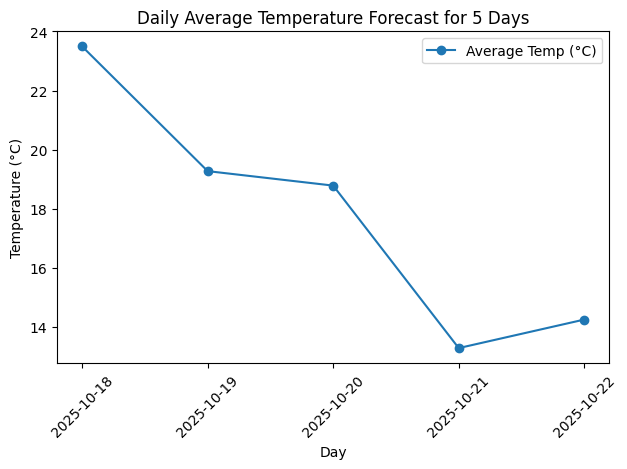


Creating temperature chart for 3 days...


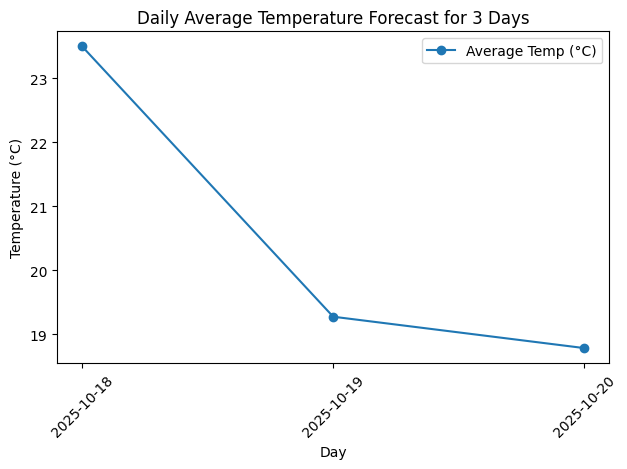

In [96]:
# Test create_temperature_visualisation
print("\nTesting create_temperature_visualisation...")
# We need weather data to test the visualization, using the data fetched for Tokyo earlier
if 'weather_processed_data' in locals() and weather_processed_data and weather_processed_data.get("list"):
    print("Creating temperature chart for 5 days...")
    create_temperature_visualisation(weather_processed_data, num_days=5, output_type='display')

    print("\nCreating temperature chart for 3 days...")
    create_temperature_visualisation(weather_processed_data, num_days=3, output_type='display')
else:
    print("Skipping temperature visualisation test as weather data is not available or not fetched.")


Testing create_precipitation_visualisation...
Creating precipitation chart for 5 days...


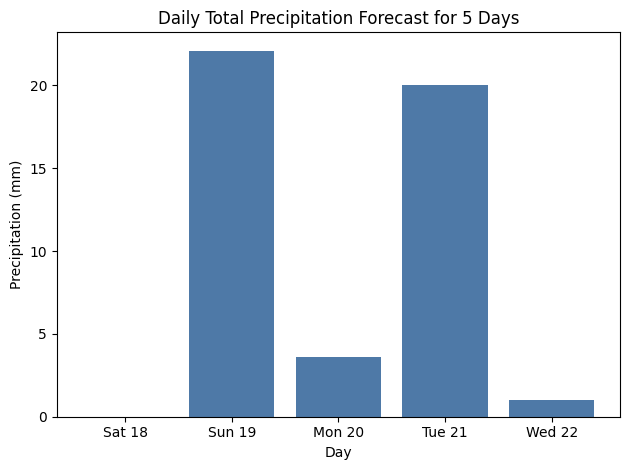


Creating precipitation chart for 3 days...


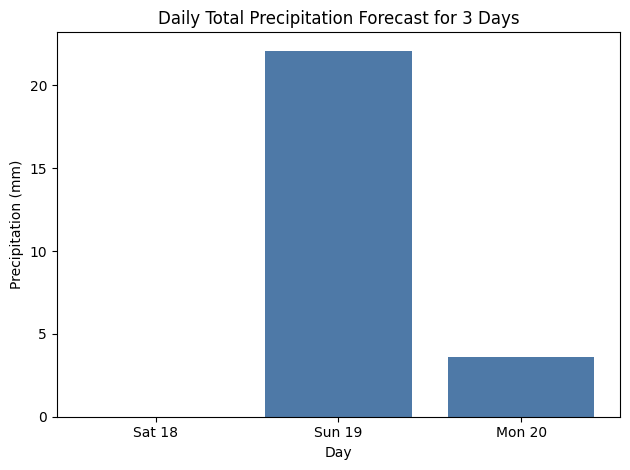

In [97]:
# Test create_precipitation_visualisation
print("\nTesting create_precipitation_visualisation...")
# We need weather data to test the visualization, using the data fetched for Tokyo earlier
if 'weather_processed_data' in locals() and weather_processed_data and weather_processed_data.get("list"):
    print("Creating precipitation chart for 5 days...")
    create_precipitation_visualisation(weather_processed_data, num_days=5, output_type='display')

    print("\nCreating precipitation chart for 3 days...")
    create_precipitation_visualisation(weather_processed_data, num_days=3, output_type='display')
else:
    print("Skipping precipitation visualisation test as weather data is not available or not fetched.")

In [ ]:
# Test parse_weather_question
print("\nTesting parse_weather_question...")

sample_question_1 = "What is the temperature in New York tomorrow?"
parsed_output_1 = parse_weather_question(sample_question_1)
print(f"Question: '{sample_question_1}'")
print("Parsed Output:")
display(parsed_output_1)

sample_question_2 = "Is it going to rain in London next 3 days?"
parsed_output_2 = parse_weather_question(sample_question_2)
print(f"\nQuestion: '{sample_question_2}'")
print("Parsed Output:")
display(parsed_output_2)

sample_question_3 = "Tell me about the wind in Tokyo today."
parsed_output_3 = parse_weather_question(sample_question_3)
print(f"\nQuestion: '{sample_question_3}'")
print("Parsed Output:")
display(parsed_output_3)

sample_question_4 = "What's the weather like?"
parsed_output_4 = parse_weather_question(sample_question_4)
print(f"\nQuestion: '{sample_question_4}'")
print("Parsed Output:")
display(parsed_output_4)

In [101]:
# Test generate_weather_response
print("\nTesting generate_weather_response...")

# We need weather data and a parsed question to test this function

# Ensure weather_processed_data is available from previous tests or fetch it
if 'weather_processed_data' not in locals() or not weather_processed_data:
    print("Fetching weather data for generate_weather_response test...")
    sample_city_for_ai = "Sydney"
    weather_processed_data = get_weather_data(city=sample_city_for_ai, forecast_days=6) # Fetch enough data for tomorrow's forecast

if weather_processed_data and weather_processed_data.get("list"):
    # Create a sample parsed question dictionary
    sample_parsed_question = {
        "question": "What is the temperature like today?",
        "location": "Sydney", # Assuming Sydney data was fetched or is available
        "time_period": "today",
        "weather_attribute": "temperature"
    }

    print(f"Using sample parsed question: {sample_parsed_question}")

    # Generate the AI response
    ai_response_output = generate_weather_response(sample_parsed_question, weather_processed_data)

    print("\nGenerated AI Response:")
    print(ai_response_output)

    # Test with a different question
    sample_parsed_question_2 = {
        "question": "Is it going to rain tomorrow?",
        "location": "Sydney",
        "time_period": "tomorrow",
        "weather_attribute": "precipitation"
    }
    print(f"\nUsing sample parsed question: {sample_parsed_question_2}")
    ai_response_output_2 = generate_weather_response(sample_parsed_question_2, weather_processed_data)
    print("\nGenerated AI Response:")
    print(ai_response_output_2)


else:
    print("Skipping generate_weather_response test as weather data is not available.")


Testing generate_weather_response...
Using sample parsed question: {'question': 'What is the temperature like today?', 'location': 'Sydney', 'time_period': 'today', 'weather_attribute': 'temperature'}

Generated AI Response:
Today's temperature in Sydney is 24.3°C.

Using sample parsed question: {'question': 'Is it going to rain tomorrow?', 'location': 'Sydney', 'time_period': 'tomorrow', 'weather_attribute': 'precipitation'}

Generated AI Response:
According to the weather information you provided, yes, it is expected to rain tomorrow (2025-10-19) with 24.18 mm of precipitation forecasted under light rainy conditions.


## ✨ Display UI

In [85]:

# Display the UI
weather_ui = create_weather_ui()
display(weather_ui)

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.